In [1]:
# Import required packages
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

2022-10-31 17:21:20.788261: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 1. Load the datasets

For the project, we provide a training set with 50000 images in the directory `../data/images/` with:
- noisy labels for all images provided in `../data/noisy_label.csv`;
- clean labels for the first 10000 images provided in `../data/clean_labels.csv`. 

In [2]:
# [DO NOT MODIFY THIS CELL]

# load the images
n_img = 50000
n_noisy = 40000
n_clean_noisy = n_img - n_noisy
imgs = np.empty((n_img,32,32,3))
for i in range(n_img):
    img_fn = f'../data/images/{i+1:05d}.png'
    imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)

# load the labels
clean_labels = np.genfromtxt('../data/clean_labels.csv', delimiter=',', dtype="int8")
noisy_labels = np.genfromtxt('../data/noisy_labels.csv', delimiter=',', dtype="int8")

For illustration, we present a small subset (of size 8) of the images with their clean and noisy labels in `clean_noisy_trainset`. You are encouraged to explore more characteristics of the label noises on the whole dataset. 

Clean labels:
 frog truck truck  deer   car   car  bird horse
Noisy labels:
  cat   dog truck  frog   dog  ship  bird  deer


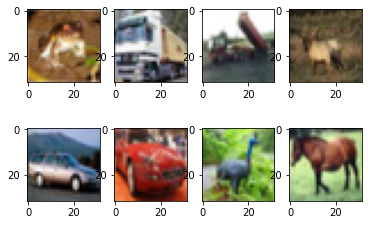

In [3]:
# [DO NOT MODIFY THIS CELL]
fig = plt.figure()

ax1 = fig.add_subplot(2,4,1)
ax1.imshow(imgs[0]/255)
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(imgs[1]/255)
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(imgs[2]/255)
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(imgs[3]/255)
ax1 = fig.add_subplot(2,4,5)
ax1.imshow(imgs[4]/255)
ax2 = fig.add_subplot(2,4,6)
ax2.imshow(imgs[5]/255)
ax3 = fig.add_subplot(2,4,7)
ax3.imshow(imgs[6]/255)
ax4 = fig.add_subplot(2,4,8)
ax4.imshow(imgs[7]/255)

# The class-label correspondence
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# print clean labels
print('Clean labels:')
print(' '.join('%5s' % classes[clean_labels[j]] for j in range(8)))
# print noisy labels
print('Noisy labels:')
print(' '.join('%5s' % classes[noisy_labels[j]] for j in range(8)))

## 2. The predictive model

We consider a baseline model directly on the noisy dataset without any label corrections. RGB histogram features are extracted to fit a logistic regression model.

### 2.1. Baseline Model

In [4]:
# [DO NOT MODIFY THIS CELL]
# RGB histogram dataset construction
no_bins = 6
bins = np.linspace(0,255,no_bins) # the range of the rgb histogram
target_vec = np.empty(n_img)
feature_mtx = np.empty((n_img,3*(len(bins)-1)))
i = 0
for i in range(n_img):
    # The target vector consists of noisy labels
    target_vec[i] = noisy_labels[i]
    
    # Use the numbers of pixels in each bin for all three channels as the features
    feature1 = np.histogram(imgs[i][:,:,0],bins=bins)[0] 
    feature2 = np.histogram(imgs[i][:,:,1],bins=bins)[0]
    feature3 = np.histogram(imgs[i][:,:,2],bins=bins)[0]
    
    # Concatenate three features
    feature_mtx[i,] = np.concatenate((feature1, feature2, feature3), axis=None)
    i += 1

In [5]:
# [DO NOT MODIFY THIS CELL]
# Train a logistic regression model 
clf = LogisticRegression(random_state=0).fit(feature_mtx, target_vec)

For the convenience of evaluation, we write the following function `predictive_model` that does the label prediction. **For your predictive model, feel free to modify the function, but make sure the function takes an RGB image of numpy.array format with dimension $32\times32\times3$  as input, and returns one single label as output.**

In [6]:
# [DO NOT MODIFY THIS CELL]
def baseline_model(image):
    '''
    This is the baseline predictive model that takes in the image and returns a label prediction
    '''
    feature1 = np.histogram(image[:,:,0],bins=bins)[0]
    feature2 = np.histogram(image[:,:,1],bins=bins)[0]
    feature3 = np.histogram(image[:,:,2],bins=bins)[0]
    feature = np.concatenate((feature1, feature2, feature3), axis=None).reshape(1,-1)
    return clf.predict(feature)

Clean labels:
 frog truck truck  deer   car   car  bird horse
Predicted baseline labels:
 frog  ship truck  frog  ship   cat  deer horse


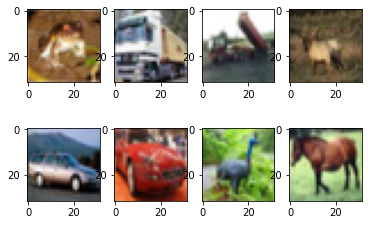

In [7]:
fig = plt.figure()

ax1 = fig.add_subplot(2,4,1)
ax1.imshow(imgs[0]/255)
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(imgs[1]/255)
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(imgs[2]/255)
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(imgs[3]/255)
ax1 = fig.add_subplot(2,4,5)
ax1.imshow(imgs[4]/255)
ax2 = fig.add_subplot(2,4,6)
ax2.imshow(imgs[5]/255)
ax3 = fig.add_subplot(2,4,7)
ax3.imshow(imgs[6]/255)
ax4 = fig.add_subplot(2,4,8)
ax4.imshow(imgs[7]/255)

print('Clean labels:')
print(' '.join('%5s' % classes[clean_labels[j]] for j in range(8)))
print('Predicted baseline labels:')
print(' '.join('%5s' % classes[int(baseline_model(imgs[j])[0])] for j in range(8)))

### 2.2. Model I

In [8]:
import os
from keras.models import Model
from keras.optimizers import Adam
from keras.applications import vgg16, vgg19, resnet, inception_v3
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from keras.utils import to_categorical
from livelossplot.inputs.keras import PlotLossesCallback
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
import seaborn as sns
from sklearn.metrics import confusion_matrix
from datetime import datetime as dt

#### Candidate Model 1: VGG-16

In [9]:
# Split the data into training set (75%) and test set (25%)
x_train, x_test, y_train, y_test = train_test_split(imgs, noisy_labels, test_size = 0.25, random_state = 4)

In [10]:
# Preprocess input
x_train_vgg16 = vgg16.preprocess_input(x_train) 
x_test_vgg16 = vgg16.preprocess_input(x_test)

# Transform labels to correct format
y_train_vec = to_categorical(y_train, num_classes=10)
y_test_vec = to_categorical(y_test, num_classes=10)

In [11]:
# Load VGG16 model
def create_model_vgg16(input_shape, n_classes, optimizer, fine_tune):
    """
    Compiles a model integrated with VGG16 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training
    fine_tune: int - The number of pre-trained layers to unfreeze
    """
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    conv_base = vgg16.VGG16(include_top=False,
                            weights='imagenet', 
                            input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    # If the arg fine_tune is set to 0, all pre-trained layers will be frozen and left un-trainable.
    # Otherwise, the last n layers will be made available for training.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers) 
    # by grabbing the conv_base outputs and flattening them.
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    # Dropout = 0.2 means one in five inputs will be randomly excluded from each update cycle.
    top_model = conv_base.output
    top_model = Flatten()(top_model)
    top_model = Dense(n_classes*8, activation='relu')(top_model)
    top_model = Dense(n_classes*4, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model) 
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


input_shape = (32, 32, 3)
n_classes=10
optim = Adam(learning_rate=0.001) 
vgg16_model = create_model_vgg16(input_shape, n_classes, optim, fine_tune = 2)

2022-10-31 17:24:14.072782: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
# ModelCheckpoint callback is used to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved.
# EarlyStopping stops training when a monitored metric has stopped improving.
# Batch size defines the number of samples to work through before updating the internal model parameters.
vgg16_checkpoint = ModelCheckpoint(filepath='vgg16.weights.best.hdf5', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, mode='min')
plot_loss = PlotLossesCallback()

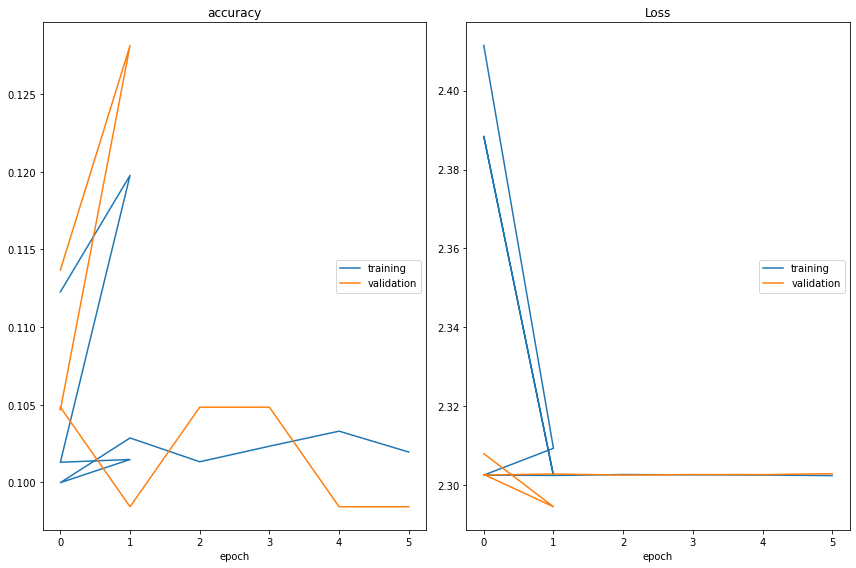

accuracy
	training         	 (min:    0.100, max:    0.120, cur:    0.102)
	validation       	 (min:    0.098, max:    0.128, cur:    0.098)
Loss
	training         	 (min:    2.302, max:    2.411, cur:    2.302)
	validation       	 (min:    2.294, max:    2.308, cur:    2.303)
1000/1000 [==============================] - 388s 388ms/step - loss: 2.3024 - accuracy: 0.1020 - val_loss: 2.3029 - val_accuracy: 0.0984
Epoch 7/50
 595/1000 [================>.............] - ETA: 2:40 - loss: 2.3027 - accuracy: 0.1008

In [ ]:
# Train the VGG16 model
# The number of epochs defines the number times that the learning algorithm will work through the entire training dataset.
vgg16_fit = vgg16_model.fit(x_train_vgg16, 
                            y_train_vec,
                            batch_size=32, # Mini-batch gradient descent
                            epochs=50,# 20
                            steps_per_epoch=1000, #1000
                            validation_split=0.2, 
                            validation_steps=200, #200
                            callbacks=[vgg16_checkpoint, early_stop, plot_loss],
                            verbose=1)

In [59]:
# Prediction & Accuracy
start = dt.now()
vgg16_model.load_weights('vgg16.weights.best.hdf5')
vgg16_preds = vgg16_model.predict(x_test_vgg16)
vgg16_pred_classes = np.argmax(vgg16_preds, axis=1)
vgg16_running = (dt.now() - start).microseconds
vgg16_acc = accuracy_score(y_test, vgg16_pred_classes)
print("VGG16 Model Accuracy: {:.2f}%".format(vgg16_acc * 100))

391/391 [==============================] - 96s 245ms/step
VGG16 Model Accuracy: 10.27%


In [16]:
def vgg16_model1(image):
    '''
    This is the VGG16 predictive model that takes in the image and returns a label prediction
    '''
    img_mtx = vgg16.preprocess_input(image[np.newaxis, :])
    vgg16_model.load_weights('vgg16.weights.best.hdf5')
    vgg16_preds = vgg16_model.predict(img_mtx)
    vgg16_pred_classes = np.argmax(vgg16_preds, axis=1)
    return int(vgg16_pred_classes[0])

# vgg16_model1(imgs[1])

#### Candidate Model 2: VGG-19

In [17]:
# Preprocess input
x_train_vgg19 = vgg19.preprocess_input(x_train) 
x_test_vgg19 = vgg19.preprocess_input(x_test)

In [18]:
# Load VGG19 model
def create_model_vgg19(input_shape, n_classes, optimizer, fine_tune):
    """
    Compiles a model integrated with VGG16 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
               If set to 0, all pretrained layers will freeze during training
    """
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = vgg19.VGG19(include_top=False,
                            weights='imagenet', 
                            input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    # If the arg fine_tune is set to 0, all pre-trained layers will be frozen and left un-trainable.
    # Otherwise, the last n layers will be made available for training.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers) 
    # by grabbing the conv_base outputs and flattening them.
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten()(top_model)
    top_model = Dense(n_classes*8, activation='relu')(top_model)
    top_model = Dense(n_classes*4, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model) 
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


input_shape = (32, 32, 3)
n_classes=10
optim = Adam(learning_rate=0.001) 
vgg19_model = create_model_vgg19(input_shape, n_classes, optim, fine_tune = 2)

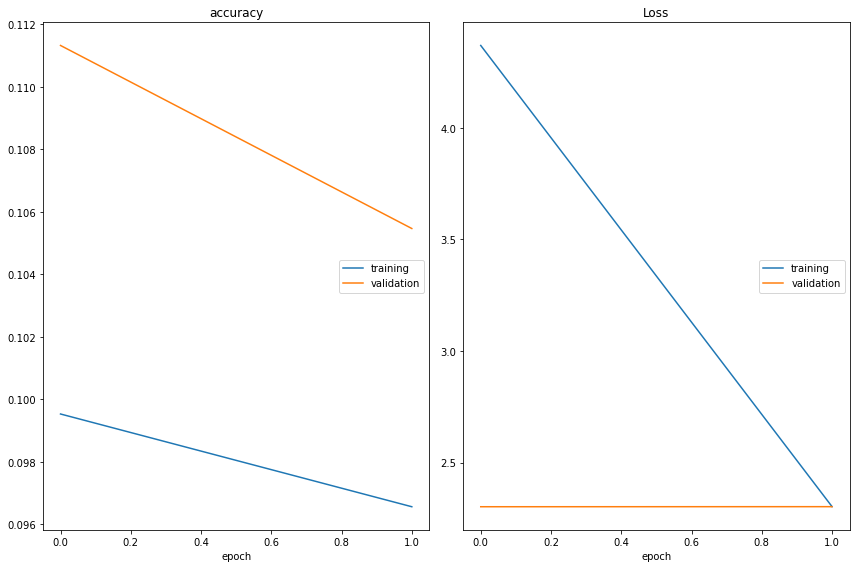

accuracy
	training         	 (min:    0.097, max:    0.100, cur:    0.097)
	validation       	 (min:    0.105, max:    0.111, cur:    0.105)
Loss
	training         	 (min:    2.303, max:    4.369, cur:    2.303)
	validation       	 (min:    2.302, max:    2.302, cur:    2.302)
100/100 [==============================] - 176s 2s/step - loss: 2.3027 - accuracy: 0.0966 - val_loss: 2.3025 - val_accuracy: 0.1055


In [19]:
# Train the VGG19 model
# ModelCheckpoint callback is used to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved.
# EarlyStopping stops training when a monitored metric has stopped improving.
# Batch size defines the number of samples to work through before updating the internal model parameters.
# The number of epochs defines the number times that the learning algorithm will work through the entire training dataset.
vgg19_checkpoint = ModelCheckpoint(filepath='vgg19.weights.best.hdf5', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, mode='min')
plot_loss = PlotLossesCallback()
vgg19_fit = vgg19_model.fit(x_train_vgg19, 
                            y_train_vec,
                            batch_size=128, # Mini-batch gradient descent
                            epochs=2,# 20
                            steps_per_epoch=100, #1000
                            validation_split=0.2, 
                            validation_steps=20, #200
                            callbacks=[vgg19_checkpoint, early_stop, plot_loss],
                            verbose=1)

In [20]:
# Prediction & Accuracy
start = dt.now()
vgg19_model.load_weights('vgg19.weights.best.hdf5')
vgg19_preds = vgg19_model.predict(x_test_vgg19)
vgg19_pred_classes = np.argmax(vgg19_preds, axis=1)
vgg19_running = (dt.now() - start).microseconds
vgg19_acc = accuracy_score(y_test, vgg19_pred_classes)
print("VGG19 Model Accuracy: {:.2f}%".format(vgg19_acc * 100))

391/391 [==============================] - 112s 286ms/step
VGG19 Model Accuracy: 10.26%


In [21]:
def vgg19_model1(image):
    '''
    This is the VGG16 predictive model that takes in the image and returns a label prediction
    '''
    img_mtx = vgg19.preprocess_input(image[np.newaxis, :])
    vgg19_model.load_weights('vgg19.weights.best.hdf5')
    vgg19_preds = vgg19_model.predict(img_mtx)
    vgg19_pred_classes = np.argmax(vgg19_preds, axis=1)
    return int(vgg19_pred_classes[0])

# vgg19_model1(imgs[1])

#### Candidate Model 3: ResNet Approach

In [22]:
# Preprocess input
x_train_resnet = resnet.preprocess_input(x_train) 
x_test_resnet = resnet.preprocess_input(x_test)

In [23]:
# Load ResNet model
def create_model_resnet(input_shape, n_classes, optimizer, fine_tune):
    """
    Compiles a model integrated with VGG16 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
               If set to 0, all pretrained layers will freeze during training
    """
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = resnet.ResNet50(include_top=False,
                                weights='imagenet', 
                                input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    # If the arg fine_tune is set to 0, all pre-trained layers will be frozen and left un-trainable.
    # Otherwise, the last n layers will be made available for training.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers) 
    # by grabbing the conv_base outputs and flattening them.
    # This is 'bootstrapping' a new top_model onto the pretrained layers.   
    top_model = conv_base.output
    top_model = Flatten()(top_model)
    top_model = Dense(n_classes*8, activation='relu')(top_model)
    top_model = Dense(n_classes*4, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model) 
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


input_shape = (32, 32, 3)
n_classes=10
optim = Adam(learning_rate=0.001) 
resnet_model = create_model_resnet(input_shape, n_classes, optim, fine_tune = 2)

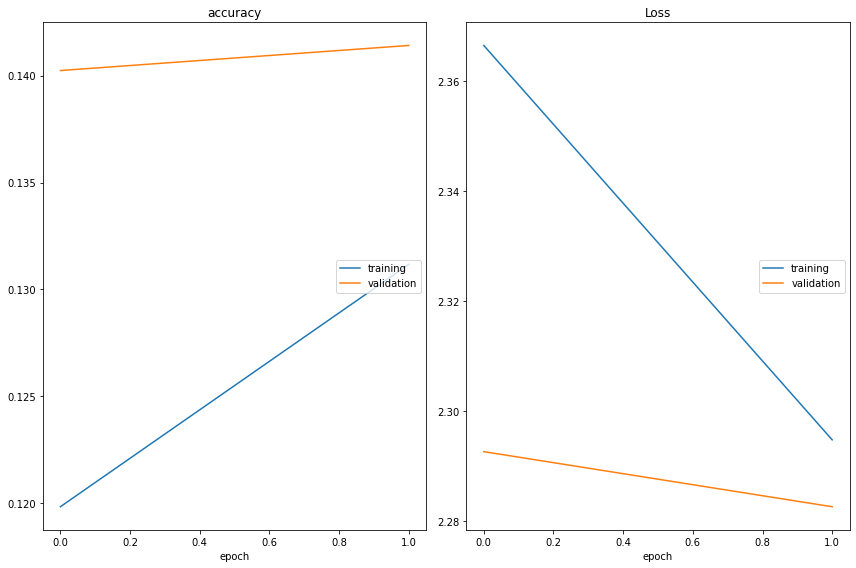

accuracy
	training         	 (min:    0.120, max:    0.131, cur:    0.131)
	validation       	 (min:    0.140, max:    0.141, cur:    0.141)
Loss
	training         	 (min:    2.295, max:    2.367, cur:    2.295)
	validation       	 (min:    2.283, max:    2.293, cur:    2.283)
100/100 [==============================] - 45s 453ms/step - loss: 2.2948 - accuracy: 0.1312 - val_loss: 2.2827 - val_accuracy: 0.1414


In [24]:
# Train the ResNet model
# ModelCheckpoint callback is used to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved.
# EarlyStopping stops training when a monitored metric has stopped improving.
# Batch size defines the number of samples to work through before updating the internal model parameters.
# The number of epochs defines the number times that the learning algorithm will work through the entire training dataset.
resnet_checkpoint = ModelCheckpoint(filepath='resnet.weights.best.hdf5', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, mode='min')
plot_loss = PlotLossesCallback()
resnet_fit = resnet_model.fit(x_train_resnet, 
                            y_train_vec,
                            batch_size=128, # Mini-batch gradient descent
                            epochs=2,# 20
                            steps_per_epoch=100, #1000
                            validation_split=0.2, 
                            validation_steps=20, #200
                            callbacks=[resnet_checkpoint, early_stop, plot_loss],
                            verbose=1)

In [25]:
# Prediction & Accuracy
start = dt.now()
resnet_model.load_weights('resnet.weights.best.hdf5')
resnet_preds = resnet_model.predict(x_test_resnet)
resnet_pred_classes = np.argmax(resnet_preds, axis=1)
resnet_running = (dt.now() - start).microseconds
resnet_acc = accuracy_score(y_test, resnet_pred_classes)
print("ResNet Model Accuracy: {:.2f}%".format(resnet_acc * 100))

391/391 [==============================] - 60s 151ms/step
ResNet Model Accuracy: 14.44%


In [26]:
def resnet_model1(image):
    '''
    This is the VGG16 predictive model that takes in the image and returns a label prediction
    '''
    img_mtx = resnet.preprocess_input(image[np.newaxis, :])
    resnet_model.load_weights('resnet.weights.best.hdf5')
    resnet_preds = resnet_model.predict(img_mtx)
    resnet_pred_classes = np.argmax(resnet_preds, axis=1)
    return int(resnet_pred_classes[0])

# resnet_model1(imgs[1])

#### Candidate Model 4: Inception

In [27]:
# Preprocess input
x_train_incep = inception_v3.preprocess_input(tf.image.resize(x_train,(75,75)).numpy()) 
x_test_incep = inception_v3.preprocess_input(tf.image.resize(x_test,(75,75)).numpy())

In [28]:
# Load InceptionV3 model
def create_model_incep(input_shape, n_classes, optimizer, fine_tune):
    """
    Compiles a model integrated with VGG16 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
               If set to 0, all pretrained layers will freeze during training
    """
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = inception_v3.InceptionV3(include_top=False,
                                weights='imagenet', 
                                input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    # If the arg fine_tune is set to 0, all pre-trained layers will be frozen and left un-trainable.
    # Otherwise, the last n layers will be made available for training.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers) 
    # by grabbing the conv_base outputs and flattening them.
    # This is 'bootstrapping' a new top_model onto the pretrained layers.   
    top_model = conv_base.output
    top_model = Flatten()(top_model)
    top_model = Dense(n_classes*8, activation='relu')(top_model)
    top_model = Dense(n_classes*4, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model) 
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


input_shape = (75, 75, 3)
n_classes=10
optim = Adam(learning_rate=0.0001) 
incep_model = create_model_incep(input_shape, n_classes, optim, fine_tune = 2)

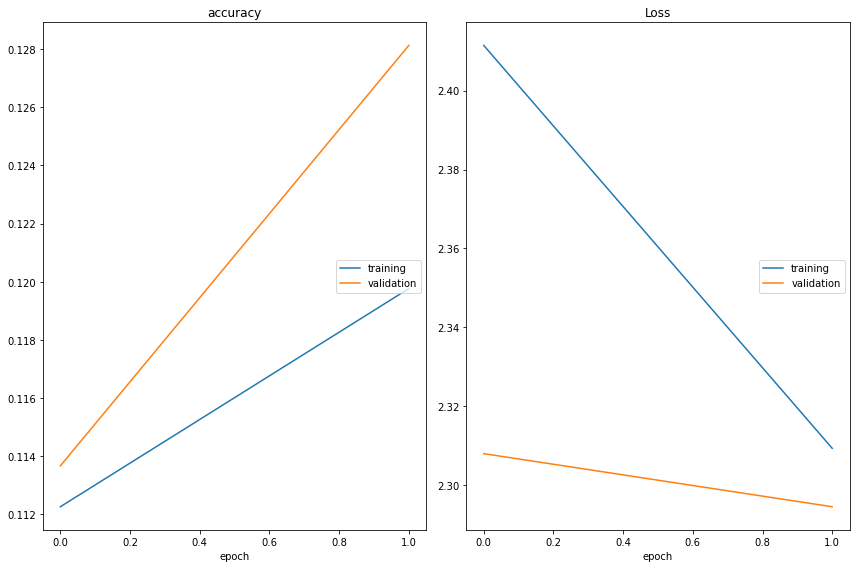

accuracy
	training         	 (min:    0.112, max:    0.120, cur:    0.120)
	validation       	 (min:    0.114, max:    0.128, cur:    0.128)
Loss
	training         	 (min:    2.309, max:    2.411, cur:    2.309)
	validation       	 (min:    2.294, max:    2.308, cur:    2.294)
100/100 [==============================] - 95s 955ms/step - loss: 2.3093 - accuracy: 0.1198 - val_loss: 2.2945 - val_accuracy: 0.1281


In [29]:
# Train the InceptionV3 model
# ModelCheckpoint callback is used to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved.
# EarlyStopping stops training when a monitored metric has stopped improving.
# Batch size defines the number of samples to work through before updating the internal model parameters.
# The number of epochs defines the number times that the learning algorithm will work through the entire training dataset.
incep_checkpoint = ModelCheckpoint(filepath='incep.weights.best.hdf5', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, mode='min')
plot_loss = PlotLossesCallback()
incep_fit = incep_model.fit(x_train_incep, 
                            y_train_vec,
                            batch_size=128, # Mini-batch gradient descent
                            epochs=2,# 20
                            steps_per_epoch=100, #1000
                            validation_split=0.2, 
                            validation_steps=20, #200
                            callbacks=[incep_checkpoint, early_stop, plot_loss],
                            verbose=1)

In [30]:
# Prediction & Accuracy
start = dt.now()
incep_model.load_weights('incep.weights.best.hdf5')
incep_preds = incep_model.predict(x_test_incep)
incep_pred_classes = np.argmax(incep_preds, axis=1)
inc_running = (dt.now() - start).microseconds
incep_acc = accuracy_score(y_test, incep_pred_classes)
print("Inception Model Accuracy: {:.2f}%".format(incep_acc * 100))

391/391 [==============================] - 82s 206ms/step
Inception Model Accuracy: 12.40%


In [31]:
def incep_model1(image):
    '''
    This is the InceptionV3 predictive model that takes in the image and returns a label prediction
    '''
    img_mtx = inception_v3.preprocess_input(tf.image.resize(image[np.newaxis, :],(75,75)).numpy()) 
    incep_model.load_weights('incep.weights.best.hdf5')
    incep_preds = incep_model.predict(img_mtx)
    incep_pred_classes = np.argmax(incep_preds, axis=1)
    return int(incep_pred_classes[0])

# incep_model1(imgs[1])

#### Candidate Model 5: SVM

In [32]:
# Split the training & test set using features
x_train, x_test, y_train, y_test = train_test_split(feature_mtx, target_vec, test_size = 0.25, random_state = 4)

In [ ]:
# GridSearch for best parameters
# param_grid = {'C': [0.1, 1, 10, 100], 
#              'gamma': [1, 0.1, 0.01, 0.001]} 
  
# grid = GridSearchCV(SVC(kernel='rbf'), param_grid, refit=True, verbose=3)
  
# fitting the model for grid search
# grid.fit(x_train, y_train)
# print(grid.best_params_)
# print(grid.best_estimator_)

In [34]:
# Train the SVM model
svm_rbf = SVC(C=10, gamma=0.001, kernel='rbf')
svm_rbf.fit(x_train, y_train);

In [35]:
# Prediction & Accuracy
# svm_rbf.score(x_train, y_train)
start = dt.now()
svm_rbf_pred_classes = []
for x in x_test:
    svm_rbf_pred_classes.append(svm_rbf.predict(x.reshape(1, -1))[0])
svm_running = (dt.now() - start).microseconds
print("SVM Model Prediction Time Cost: {:.0f}s".format(svm_running))
svm_rbf_acc = svm_rbf.score(x_test, y_test)
print("SVM Model Accuracy: {:.2f}%".format(svm_rbf_acc * 100))

SVM Model Prediction Time Cost: 571206s
SVM Model Accuracy: 9.95%


In [36]:
def svm_model1(image):
    '''
    This is the baseline predictive model that takes in the image and returns a label prediction
    '''
    feature1 = np.histogram(image[:,:,0],bins=bins)[0]
    feature2 = np.histogram(image[:,:,1],bins=bins)[0]
    feature3 = np.histogram(image[:,:,2],bins=bins)[0]
    feature = np.concatenate((feature1, feature2, feature3), axis=None).reshape(1,-1)
    return svm_rbf.predict(feature.reshape(1,-1))

#### Candidate Model 6: KNN

In [ ]:
# GridSearch for best parameters
# knn = KNeighborsClassifier()
# k_range = list(range(1, 31))
# param_grid = dict(n_neighbors=k_range)
  
# defining parameter range
# grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', return_train_score=False, verbose=1)
  
# fitting the model for grid search
# grid_search=grid.fit(x_train, y_train)
# print(grid_search.best_params_)
# print(grid_search.best_estimator_)

In [37]:
# Train the KNN model
knn = KNeighborsClassifier(n_neighbors=27)
knn.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=27)

In [38]:
# Prediction & Accuracy
# knn.score(x_train, y_train)
start = dt.now()
knn_pred_classes = []
for x in x_test:
    knn_pred_classes.append(knn.predict(x.reshape(1, -1))[0])
knn_running = (dt.now() - start).microseconds
print("KNN Model Prediction Time Cost: {:.0f}s".format(knn_running))
knn_acc = knn.score(x_test, y_test)
print("KNN Model Accuracy: {:.2f}%".format(knn_acc * 100))

KNN Model Prediction Time Cost: 217746s
KNN Model Accuracy: 13.93%


In [39]:
def knn_model1(image):
    '''
    This is the baseline predictive model that takes in the image and returns a label prediction
    '''
    feature1 = np.histogram(image[:,:,0],bins=bins)[0]
    feature2 = np.histogram(image[:,:,1],bins=bins)[0]
    feature3 = np.histogram(image[:,:,2],bins=bins)[0]
    feature = np.concatenate((feature1, feature2, feature3), axis=None).reshape(1,-1)
    return knn.predict(feature.reshape(1,-1))

#### Candidate Model 7: Random Forest

In [ ]:
# GridSearch for best parameters
# rfc = RandomForestRegressor()

# param_grid = { 
#     'n_estimators': [200, 500],
#     'max_depth' : [4,5,6,7,8]
# }

# rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
# rfc_grid = rfc.fit(x_train, y_train)
# print(rfc_grid.best_estimator_)

In [40]:
# Train the Random Forest model
rfc = RandomForestRegressor(max_depth=5, n_estimators=500)
rfc.fit(x_train, y_train)

RandomForestRegressor(max_depth=5, n_estimators=500)

In [41]:
# Prediction & Accuracy
# rfc.score(x_train, y_train)
start = dt.now()
rfc_pred_classes = []
for x in x_test:
    rfc_pred_classes.append(rfc.predict(x.reshape(1, -1))[0])
rfc_running = (dt.now() - start).microseconds
print("Random Forest Model Prediction Time Cost: {:.0f}s".format(rfc_running))
rfc_acc = rfc.score(x_test, y_test)
print("Random Forest Model Accuracy: {:.2f}%".format(rfc_acc * 100))

Random Forest Model Prediction Time Cost: 182086s
Random Forest Model Accuracy: 0.83%


In [42]:
def rfc_model1(image):
    '''
    This is the baseline predictive model that takes in the image and returns a label prediction
    '''
    feature1 = np.histogram(image[:,:,0],bins=bins)[0]
    feature2 = np.histogram(image[:,:,1],bins=bins)[0]
    feature3 = np.histogram(image[:,:,2],bins=bins)[0]
    feature = np.concatenate((feature1, feature2, feature3), axis=None).reshape(1,-1)
    return rfc.predict(feature.reshape(1,-1))

#### Candidate Model 8: Boosting

In [44]:
# GridSearch for best parameters
# gbc = GradientBoostingClassifier()

# param_grid = { 
#     'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5]
# }

# gbc = GridSearchCV(estimator=gbc, param_grid=param_grid, cv=5)
# gbc_grid = gbc.fit(x_train, y_train)

# print(gbc_grid.best_params_)

In [45]:
# Train the Boosting model
gbc = GradientBoostingClassifier(learning_rate=0.1)
gbc.fit(x_train, y_train)

GradientBoostingClassifier()

In [46]:
# Prediction & Accuracy
# gbc.score(x_train, y_train)
start = dt.now()
gbc_pred_classes = []
for x in x_test:
    gbc_pred_classes.append(gbc.predict(x.reshape(1, -1))[0])
gbc_running = (dt.now() - start).microseconds
print("Boosting Model Prediction Time Cost: {:.0f}s".format(gbc_running))
gbc_acc = gbc.score(x_test, y_test)
print("Boosting Model Accuracy: {:.2f}%".format(gbc_acc * 100))

Boosting Model Prediction Time Cost: 596267s
Boosting Model Accuracy: 16.38%


In [47]:
def gbc_model1(image):
    '''
    This is the baseline predictive model that takes in the image and returns a label prediction
    '''
    feature1 = np.histogram(image[:,:,0],bins=bins)[0]
    feature2 = np.histogram(image[:,:,1],bins=bins)[0]
    feature3 = np.histogram(image[:,:,2],bins=bins)[0]
    feature = np.concatenate((feature1, feature2, feature3), axis=None).reshape(1,-1)
    return gbc.predict(feature.reshape(1,-1))

#### Candidate Model 9: Baseline Model

In [48]:
# Train the Baseline Model
clf_model1 = LogisticRegression(random_state=0).fit(x_train, y_train)

In [50]:
# Prediction & Accuracy
start = dt.now()
clf_pred_classes = []
for x in x_test:
    clf_pred_classes.append(clf_model1.predict(x.reshape(1, -1))[0])
clf_running = (dt.now() - start).microseconds
print("Baseline Model Prediction Time Cost: {:.0f}s".format(clf_running))
clf_acc = clf_model1.score(x_test, y_test)
print("Baseline Model Accuracy: {:.2f}%".format(clf_acc * 100))

Baseline Model Prediction Time Cost: 783915s
Baseline Model Accuracy: 14.03%


#### Model I Comparison

In [52]:
# Accuracy & Time Cost table for all candidate models
model1_accuracy = np.array([['Baseline', 'VGG16', 'VGG19', 'ResNet', 'Inception', 'SVM', 'KNN', 'RandomForest', 'GBC'], 
                            [clf_acc, vgg16_acc, vgg19_acc, resnet_acc, incep_acc, svm_rbf_acc, knn_acc, rfc_acc, gbc_acc],
                            [clf_running, vgg16_running, vgg19_running, resnet_running, inc_running, svm_running, knn_running, rfc_running, gbc_running]])

evaluation_df = pd.DataFrame(data=model1_accuracy.T, columns=['Models', 'Accuracy','Predict Running Time (microseconds)'])
evaluation_df = evaluation_df.sort_values(by = 'Accuracy', ascending = False)
evaluation_df

,Models,Accuracy,Predict Running Time (microseconds)
8,GBC,0.16384,596267
3,ResNet,0.1444,373484
0,Baseline,0.14032,783915
6,KNN,0.13928,217746
4,Inception,0.124,784665
1,VGG16,0.10272,924177
2,VGG19,0.10256,137236
5,SVM,0.09952,571206
7,RandomForest,0.008289362078489737,182086


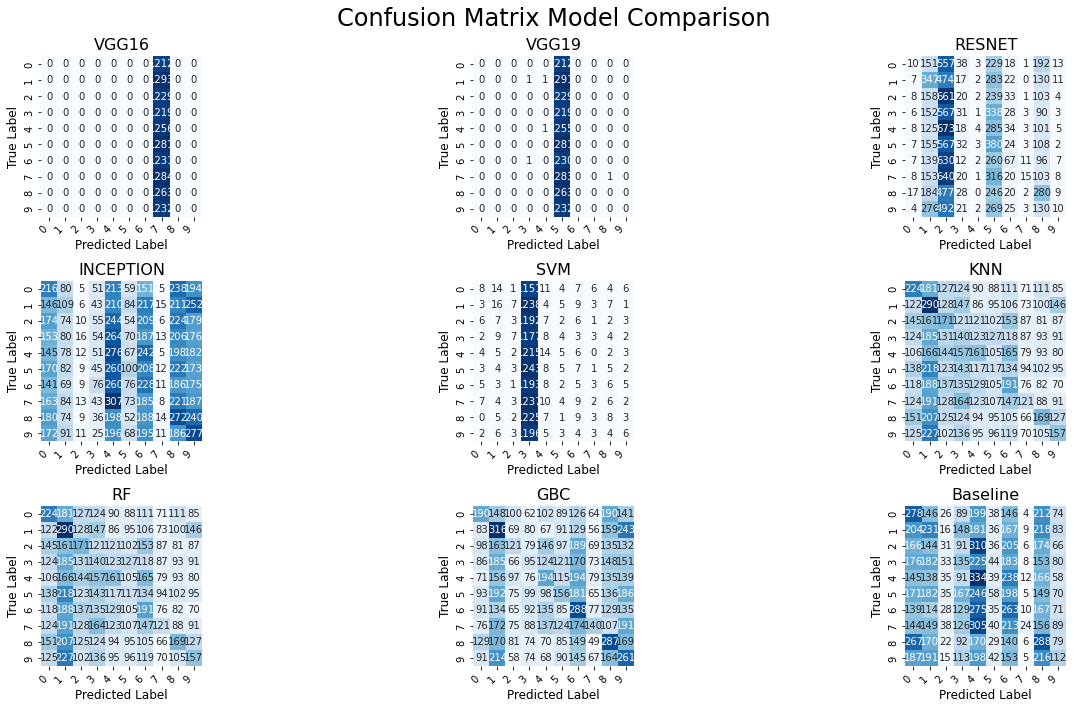

In [57]:
# Confusion matrix for all candidate models
class_names = [x for x in range(0, 10)] 

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, [[ax1, ax2, ax3], [ax4, ax5, ax6], [ax7, ax8, ax9]] = plt.subplots(3, 3, figsize=(20, 10))
   
plot_heatmap(y_test, vgg16_pred_classes, class_names, ax1, title="VGG16")    
plot_heatmap(y_test, vgg19_pred_classes, class_names, ax2, title="VGG19")    
plot_heatmap(y_test, resnet_pred_classes, class_names, ax3, title="RESNET")    
plot_heatmap(y_test, incep_pred_classes, class_names, ax4, title="INCEPTION") 
plot_heatmap(y_test, svm_rbf_pred_classes, class_names, ax5, title="SVM")    
plot_heatmap(y_test, knn_pred_classes, class_names, ax6, title="KNN") 
plot_heatmap(y_test, knn_pred_classes, class_names, ax7, title="RF")    #CHANGE
plot_heatmap(y_test, gbc_pred_classes, class_names, ax8, title="GBC") 
plot_heatmap(y_test, clf_pred_classes, class_names, ax9, title="Baseline")    

fig.suptitle("Confusion Matrix Model Comparison", fontsize=24)
fig.tight_layout()
plt.show()

#### Best Model for Model I

In [ ]:
def model_I(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    # write your code here...

### 2.3. Model II

In [ ]:
# [ADD WEAKLY SUPERVISED LEARNING FEATURE TO MODEL I]

# write your code here...

def model_II(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    # write your code here...

In [ ]:
import os
from inception import maybe_download, Inception, transfer_values_cache

model = Inception()

output_path = "inception/"
inception_train_output_path = os.path.join(output_path, 'inception_cifar10_train.pkl')

inception_train_output = transfer_values_cache(cache_path=inception_train_output_path,
                                               images=imgs,
                                               model=model)

In [ ]:
inception_train_output = pd.read_pickle('inception/inception_cifar10_train.pkl')
inception_train_output
# inception_train_output.shape
# clean_labels.shape

## 3. Evaluation

For assessment, we will evaluate your final model on a hidden test dataset with clean labels by the `evaluation` function defined as follows. Although you will not have the access to the test set, the function would be useful for the model developments. For example, you can split the small training set, using one portion for weakly supervised learning and the other for validation purpose. 

In [ ]:
# [DO NOT MODIFY THIS CELL]
# Precision: precentage of correct positive predictions relative to total positive predictions
# Recall: percentage of correct positive predictions relative to total actual positives
# F1 Score: a weighted harmonic mean of precision and recall. The closer to 1, the better the model

def evaluation(model, test_labels, test_imgs):
    y_true = test_labels
    y_pred = []
    for image in test_imgs:
        y_pred.append(model(image))
    print(classification_report(y_true, y_pred))

In [ ]:
# Model 1 Evaluation
model1_eva = evaluation(model_I,y_test,x_test)

In [ ]:
# [DO NOT MODIFY THIS CELL]
# This is the code for evaluating the prediction performance on a testset
# You will get an error if running this cell, as you do not have the testset
# Nonetheless, you can create your own validation set to run the evlauation
n_test = 10000
test_labels = np.genfromtxt('../data/test_labels.csv', delimiter=',', dtype="int8")
test_imgs = np.empty((n_test,32,32,3))
for i in range(n_test):
    img_fn = f'../data/test_images/test{i+1:05d}.png'
    test_imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)
evaluation(baseline_model, test_labels, test_imgs)

The overall accuracy is $0.24$, which is better than random guess (which should have a accuracy around $0.10$). For the project, you should try to improve the performance by the following strategies:

- Consider a better choice of model architectures, hyperparameters, or training scheme for the predictive model;
- Use both `clean_noisy_trainset` and `noisy_trainset` for model training via **weakly supervised learning** methods. One possible solution is to train a "label-correction" model using the former, correct the labels in the latter, and train the final predictive model using the corrected dataset.
- Apply techniques such as $k$-fold cross validation to avoid overfitting;
- Any other reasonable strategies.